# Define paths

In [1]:
from pathlib import Path

project_folder = str(Path(Path.cwd()).parents[1])

plots_folder = project_folder + "/TeX/figs/"

# Import solar model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

solar_model = pd.read_csv("./Data/bs2005agsopflux.csv", 
                          usecols=[1, 3, 7, 13],
                          names = ['radius', 'density_log_10', '8B fraction', 'hep fraction'],
                          sep=" ", skiprows=27, header=None)

solar_model['density'] = 10**solar_model['density_log_10']
solar_model

,radius,density_log_10,8B fraction,hep fraction,density
0,0.00041,2.011,0.000005,1.661000e-07,102.565193
1,0.00082,2.011,0.000014,4.865000e-07,102.565193
2,0.00123,2.011,0.000023,8.074000e-07,102.565193
3,0.00164,2.011,0.000035,1.245000e-06,102.565193
4,0.00205,2.011,0.000053,1.857000e-06,102.565193
...,...,...,...,...,...
1214,0.49795,0.071,0.000000,2.902000e-10,1.177606
1215,0.49836,0.069,0.000000,2.843000e-10,1.172195
1216,0.49877,0.067,0.000000,2.785000e-10,1.166810
1217,0.49918,0.065,0.000000,2.728000e-10,1.161449


<AxesSubplot:xlabel='r', ylabel='$n_e(r)$ [mol/cm${}^3$]'>

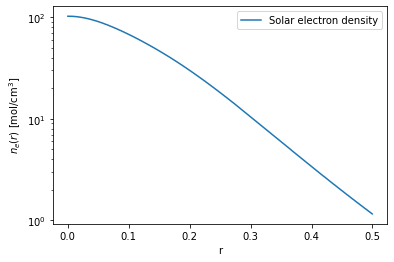

In [3]:
plot = solar_model.plot(x='radius', y='density', logy=True)
plot.set_xlabel("r")
plot.set_ylabel("$n_e(r)$ [mol/cm${}^3$]")
plot.legend(labels=['Solar electron density'])

plt.savefig(plots_folder + "sun_density.pdf")

plot

# Compute solar neutrino survival probability at Sun surface

In [4]:
def Vk(Deltam2, E, ne):
    """Vk(Deltam2, E, ne) computes the ratio V/k between the matter and vacuum terms in neutrino oscillations.
    - Deltam2 is the squared mass difference, in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3;
See also Eq.s 4.17, 4.18 in 1802.05781."""
    return (3.868e-7)/(2.533) * (ne / (Deltam2 / E))

In [5]:
from numpy import cos, sin, arcsin, tan, arctan, pi

def th12_M (th12, th13, DeltamSq21, E, ne):
    """th12_M(th12, th13, DeltamSq21, E, ne) computes the mixing angle \theta_{12} in matter.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSq21 is the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arctan(tan(2*th12) / (1 - (cos(th13)**2)/(cos(2* th12)) * Vk(DeltamSq21, E, ne))) / 2) % (pi/2)


def th13_M (th13, DeltamSq31, E, ne):
    """th13_M(th13, DeltamSq31, E, ne) computes the mixing angle \theta_{13} in matter.
    - th13 is the vacuum mixing angles \theta_{13} in radians;
    - DeltamSq31 is the vacuum squared mass difference between mass eigenstates 3 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arcsin(sin(th13) * (1 + Vk(DeltamSq31, E, ne) * cos(th13)**2))) % (pi/2)

In [6]:
def Pnuenue (th12, th13, DeltamSq21, DeltamSq31, E, ne):
    """Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne) computes the survival probability of an electron neutrino
    neutrino at the Sun surface in the adiabatic approximation, as a function of vacuum oscillation parameters.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density at neutrino production point, in units of mol/cm^3.
See also Eq. 6.14 in FiuzadeBarros:2011qna."""
    th12m = th12_M(th12, th13, DeltamSq21, E, ne)
    th13m = th13_M(th13, DeltamSq31, E, ne)
    return cos(th13)**2 * cos(th13m)**2 * (cos(th12)**2 * cos(th12m)**2 + sin(th12)**2 * sin(th12m)**2) + sin(th13)**2 * sin(th13m)**2

<AxesSubplot:xlabel='r', ylabel='Neutrino fraction'>

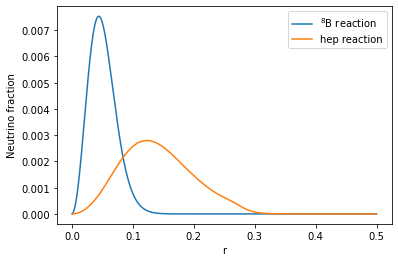

In [7]:
plot = solar_model.plot(x='radius', y=['8B fraction', 'hep fraction'])
plot.set_xlabel('r')
plot.set_ylabel('Neutrino fraction')
plot.legend(labels=['${}^8$B reaction', 'hep reaction'])

plt.savefig(plots_folder + "reaction_fraction.pdf")

plot

In [8]:
from scipy import integrate
import numpy as np

def PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction):
    """PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction) computes the
    survival probability at Sun surface for an electron with energy E produced in a specific reaction.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - radius_samples is a list of solar relative radius values where density and fraction are sampled;
    - density is the list of electron densities at radii radius_samples, in units of mol/cm^3;
    - fraction is the relative fraction of neutrinos produced in the considered reaction, sampled at radius_samples."""
    
    IntegratedFraction = integrate.trapezoid(y=fraction, x=radius_samples)
    PnuenueRadius = np.array([Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne_r) for ne_r in density])
    
    return integrate.trapezoid(y=(PnuenueRadius * fraction), x = radius_samples) / IntegratedFraction

In [9]:
from math import sqrt

th12 = arctan(sqrt(0.469))
th13 = arcsin(sqrt(0.01))
DeltamSq21 = 7.9e-5
DeltamSq31 = 2.46e-3
E = 10
ne = 100
radius_samples = solar_model.radius
density = solar_model.density
fraction = solar_model['8B fraction']

xrange = np.arange(1,20,0.1)
ProbB8 = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['8B fraction']) for E in xrange]
Probhep = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['hep fraction']) for E in xrange]

In [10]:
SNO_B8 = pd.read_csv("./Data/B8.csv", names=['energy', 'Pnuenue'])
SNO_hep = pd.read_csv("./Data/hep.csv", names=['energy', 'Pnuenue'])

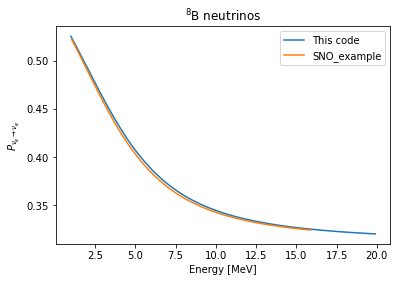

In [11]:
plt.plot(xrange, ProbB8, label="This code")
plt.plot(SNO_B8.energy, SNO_B8.Pnuenue, label='SNO_example')
plt.title("${}^8$B neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "8B_SNO_cmparison.pdf")

plt.show()

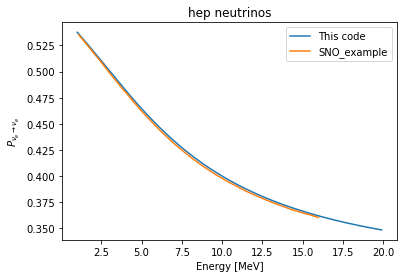

In [12]:
plt.plot(xrange, Probhep, label="This code")
plt.plot(SNO_hep.energy, SNO_hep.Pnuenue, label='SNO_example')
plt.title("hep neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "hep_SNO_comparison.pdf")

plt.show()

# Earth regeneration

### It is not necessary to define a new function for undergroud detector:
- for $0 \leq \eta \leq \pi/2$: use total path for first half of propagation, then stop at $r_{det} = 1 - h$ for second half;
- for $\pi/2 \leq \eta \leq \pi$: just use downstream path (with constant density? The density variation is at most $10^{-4}$ for SNO)

In [13]:
import numpy as np
from math import sin, cos, sqrt

def EarthDensity (x = 0, eta = 0, integrated = False): 
    """EarthDensity(x, eta, integrated) computes:
    - if integrated = False: the value of Earth electron density in units of mol/cm^3 for trajectory coordinate 
    x and nadir angle eta;
    -if integrated = True: two lists containing the values of the integrated electron 
    densities along each shell crossed by a path with nadir angle eta, to be inputed in 
    the 1st and 2nd order terms in the evolutor Magnus expansion.
See hep-ph/9702343 for the definition of trajectory coordinate."""
    
    x = np.abs(x)
    
    # If x > cos(eta) the trajectory coordinate is beyond Earth surface, thus density is zero.
    if ((~integrated) & (x > cos(eta))):
        return 0
    else:
        # Define the Earth density parametrisation, in units of mol/cm^3, following hep-ph/9702343
        alpha = np.array([6.099, 5.803, 3.156, -5.376, 11.540])
        beta = np.array([-4.119, -3.653, -1.459, 19.210, -20.280])
        gamma = np.array([0, -1.086, 0.280, -12.520, 10.410])

        rj = np.array([0.192, 0.546, 0.895, 0.937, 1])

        # Select the index "idx_shells" in rj such that for i >= idx_shells => rj[i] > sin(eta)
        # The shells having rj[i] > sin(eta) are the ones crossed by a path with nadir angle = eta
        idx_shells = np.searchsorted(rj, sin(eta))
        
        # Keep only the parameters for the shells crossed by the path with nadir angle eta
        alpha_prime = alpha[idx_shells::] + beta[idx_shells::] * sin(eta)**2 + gamma[idx_shells::] * sin(eta)**4
        beta_prime = beta[idx_shells::] + 2 * gamma[idx_shells::] * sin(eta)**2
        gamma_prime = gamma[idx_shells::]

        # Compute the value of the trajectory coordinates xj at each shell crossing
        xj = np.sqrt( (rj[idx_shells::])**2 - sin(eta)**2 )

        # The index "idx" determines within which shell xj[idx] the point x is
        idx = np.searchsorted(xj, x)
        
        # If integrated = true, the function returns the values of the integrated electron densities for the
        # path along each crossed shell
        if integrated:
            # Define xj_zero, a list containing the values of trajectory coordinates for each shell boundary
            # (including the lower end x = 0), user to perform integration on each shell
            xj_zero = np.insert(xj, 0, 0)
            
            # Return the value of the integrated densities along each crossed shell
            return [
                [(xj_zero[i+1] - xj_zero[i]) for i in range(len(alpha_prime))],
                [(alpha_prime[i] * (xj_zero[i+1] - xj_zero[i]) + beta_prime[i] * (xj_zero[i+1]**3 - xj_zero[i]**3) / 3 + gamma_prime[i] * (xj_zero[i+1]**5 - xj_zero[i]**5) / 5) for i in range(len(alpha_prime))],
                [( (xj_zero[i+1] - xj_zero[i])**3 * (xj_zero[i+1] + xj_zero[i]) * (5 * beta_prime[i] + 2 * gamma_prime[i] * (2 * xj_zero[i]**2 + 2 * xj_zero[i+1]**2 + xj_zero[i]*xj_zero[i+1])) / 30) for i in range(len(alpha_prime))]
            ]
       
        # If integrated = False, return the value of electron density at trajectory point x for nadir angle eta
        else:
            return alpha_prime[idx] + beta_prime[idx] * x**2 + gamma_prime[idx] * x**4

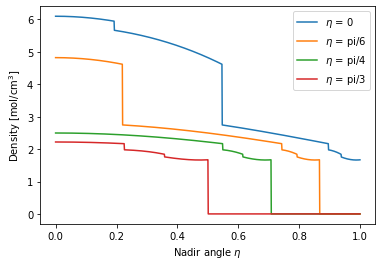

In [14]:
import matplotlib.pyplot as plt
from math import pi

x = np.arange(0,1,0.001)
eta = [0, pi/6, pi/4, pi/3]
labels = ["0", "pi/6", "pi/4", "pi/3"]

density = [ [EarthDensity(r, n) for r in x] for n in eta]

plt.xlabel("Nadir angle $\eta$")
plt.ylabel("Density [mol/cm${}^3$]")
for i in range(len(density)):
    plt.plot(x,density[i], label = "$\eta$ = %s" %labels[i])
plt.legend()
plt.savefig(plots_folder + "earth_density.pdf")
    
plt.show()

In [15]:
h = 2 / 6.371e3

(EarthDensity(1) - EarthDensity(1-h))/(EarthDensity(1) + EarthDensity(1-h))

0.00010027377254072573

In [84]:
# Works for eta=0, check for different values

DeltamSq21 = 7.42e-5
DeltamSq31 = 2.514e-3
E = 10
[th12, th13, th23, d] = [0.583638, 0.149575, 0.855211, 3.40339]
eta = 0

from math import sin, cos
from cmath import exp
from scipy.linalg import expm
from numpy.linalg import multi_dot

R_E = 6.371e6 # meters

def R23(th):
    return np.matrix([
        [1, 0, 0],
        [0, cos(th), sin(th)],
        [0, -sin(th), cos(th)]
    ])

def R13(th):
    return np.matrix([
        [cos(th), 0, sin(th)],
        [0, 1, 0],
        [-sin(th), 0, cos(th)]
    ])

def R12(th):
    return np.matrix([
        [cos(th), sin(th), 0],
        [-sin(th), cos(th), 0],
        [0, 0, 1]
    ])

def Delta(d):
    return np.matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, exp(1j*d)]
    ])


[k1, k2, k3] = 2.533 * np.array([0, DeltamSq21, DeltamSq31]) / E

r13 = R13(th13)
r12 = R12(th12)
r23 = R23(th23)
delta = Delta(d)

pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

k = np.matrix(np.diag([k1, k2, k3]))

H0 = r13 * r12 * k * r12.transpose() * r13.transpose()

H2_12 = (k2 - k1) * cos(th12) * cos(th13) * sin(th12)
H2_13 = sin(th13) * cos(th13) * ((k2 - k1) * (2 * cos(th12)**2 - 1) + 2 * k3 - k1 - k2) / 2
H2 = np.array([
    [0, H2_12, H2_13],
    [-H2_12, 0, 0],
    [-H2_13, 0, 0]
])

ME_density = EarthDensity(eta=eta, integrated=True)

# Need to understand if R_E or R_E^2 in ME2!
ME1 = [- 1j * R_E * (H0 * ME_density[0][shell] + np.diag([3.868e-7 * (ME_density[1][shell]), 0, 0]) ) for shell in range(len(ME_density[0]))]
ME2 = [- np.matrix(R_E**2 * H2 * 3.868e-7 * (ME_density[2][shell]) / 2) for shell in range(len(ME_density[0]))]

ME12 = [expm(ME1[i] + ME2[i]) for i in reversed(range(len(ME1)))]

evolutor_half = multi_dot(ME12) if len(ME12) > 1 else ME12[0]

evolutor = multi_dot([r23, delta.conjugate(), evolutor_half, evolutor_half.transpose(), delta, r23.transpose()])

probabilities = np.square(np.abs(evolutor * pmns[:,1].conjugate()))

probabilities

matrix([[0.31028351],
        [0.36942723],
        [0.32028926]])

Second order term negligible?!?

In [75]:
ME_density[0]

[0.192, 0.35400000000000004, 0.349, 0.04200000000000004, 0.06299999999999994]

In [58]:
ME_density[1]

[1.161290059776,
 1.8541963763742078,
 0.861385973739225,
 0.08070536506405857,
 0.10642047874887262]

In [59]:
ME_density[2]

[-0.000932922261504,
 -0.021769123758140954,
 -0.011822806683999936,
 -4.0867791497777754e-05,
 -5.96228798034878e-05]

In [85]:
ME1[1]

matrix([[0.  -49.04813424j, 0.  -19.27446807j, 0. -209.73133867j],
        [0.  -19.27446807j, 0.  -29.51647947j, 0.   +2.90467271j],
        [0. -209.73133867j, 0.   +2.90467271j, 0.-1404.58149532j]])

In [86]:
ME2[1]

matrix([[  0.        ,   1.46044149,  15.89150724],
        [ -1.46044149,   0.        ,   0.        ],
        [-15.89150724,   0.        ,   0.        ]])

In [87]:
E

10

In [374]:
ME1

[matrix([[0. -26.98588311j, 0. -10.45394878j, 0.-113.75259047j],
         [0. -10.45394878j, 0. -16.00893802j, 0.  +1.57541571j],
         [0.-113.75259047j, 0.  +1.57541571j, 0.-761.80691272j]]),
 matrix([[0.  -49.04813424j, 0.  -19.27446807j, 0. -209.73133867j],
         [0.  -19.27446807j, 0.  -29.51647947j, 0.   +2.90467271j],
         [0. -209.73133867j, 0.   +2.90467271j, 0.-1404.58149532j]]),
 matrix([[0.  -45.97331668j, 0.  -19.00222982j, 0. -206.76903163j],
         [0.  -19.00222982j, 0.  -29.09958005j, 0.   +2.86364626j],
         [0. -206.76903163j, 0.   +2.86364626j, 0.-1384.74277364j]]),
 matrix([[0.  -5.47603213j, 0.  -2.2868013j , 0. -24.88337916j],
         [0.  -2.2868013j , 0.  -3.50195519j, 0.  +0.34462219j],
         [0. -24.88337916j, 0.  +0.34462219j, 0.-166.64526216j]]),
 matrix([[0.  -8.17797679j, 0.  -3.43020194j, 0. -37.32506875j],
         [0.  -3.43020194j, 0.  -5.25293279j, 0.  +0.51693328j],
         [0. -37.32506875j, 0.  +0.51693328j, 0.-249.96789324j]]

In [375]:
ME2

[matrix([[ 0.00000000e+00,  9.82383513e-09,  1.06896133e-07],
         [-9.82383513e-09,  0.00000000e+00,  0.00000000e+00],
         [-1.06896133e-07,  0.00000000e+00,  0.00000000e+00]]),
 matrix([[ 0.00000000e+00,  2.29232693e-07,  2.49435053e-06],
         [-2.29232693e-07,  0.00000000e+00,  0.00000000e+00],
         [-2.49435053e-06,  0.00000000e+00,  0.00000000e+00]]),
 matrix([[ 0.00000000e+00,  1.24496229e-07,  1.35468127e-06],
         [-1.24496229e-07,  0.00000000e+00,  0.00000000e+00],
         [-1.35468127e-06,  0.00000000e+00,  0.00000000e+00]]),
 matrix([[ 0.00000000e+00,  4.30345016e-10,  4.68271477e-09],
         [-4.30345016e-10,  0.00000000e+00,  0.00000000e+00],
         [-4.68271477e-09,  0.00000000e+00,  0.00000000e+00]]),
 matrix([[ 0.00000000e+00,  6.27839388e-10,  6.83171099e-09],
         [-6.27839388e-10,  0.00000000e+00,  0.00000000e+00],
         [-6.83171099e-09,  0.00000000e+00,  0.00000000e+00]])]

In [363]:
evolutor_half.transpose()

AttributeError: 'list' object has no attribute 'transpose'

In [350]:
multi_dot([r23, delta.conjugate(),evolutor_half])

matrix([[ 0.30722396-0.229349j  , -0.90127279+0.0153635j ,
         -0.19722534+0.03982416j],
        [-0.45481904-0.08844762j, -0.31691531-0.13028938j,
          0.79079445-0.20627693j],
        [ 0.79821913-0.03428354j,  0.16517289+0.2068299j ,
          0.50711214-0.18560023j]])

In [20]:
from scipy.integrate import complex_ode

In [21]:
def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * R_E * np.dot(H + 3.868e-7 * np.diag([EarthDensity(t), 0, 0]), [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model).set_integrator("Isoda")

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


In [22]:
nu.set_integrator("Isoda")
nu.set_initial_value(nu0, -1)

t1 = 1
dt = 1e-2
while nu.successful() and nu.t < t1:
    nu.integrate(nu.t+dt)
    
print(nu.t, nu.y, nu.successful())

capi_return is NULL
Call-back cb_f_in_dvode__user__routines failed.


NameError: name 'H' is not defined

In [324]:
nu.set_integrator("Isoda")
nu.set_initial_value(nu0, -1)

x = np.arange(-1,1,1e-3)

sol = [np.square(np.abs(nu.integrate(xi))) for xi in x[1::]]

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


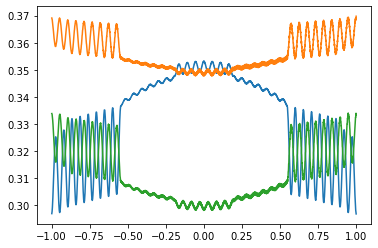

In [325]:
plt.plot(x[1::], sol)

In [1]:
from cmath import exp

In [8]:
def expint (la, lb, b, c, xi, xf):
    return - 1j * (exp(1j*lb*(-xf + xi)) * 
                   (b *(la - lb)**2 *((-1 + 1j) + la* xf - lb *xf)* ((1 + 1j) + la* xf - lb* xf) + c*
                    (24 + (la - lb)* xf *(-24* 1j + (la - lb)* xf *(-12 + (la - lb)* xf *(4 *1j + la* xf - lb *xf)))) 
                    + ((la - lb)**4 *(5* b *(-xf**3 + xi**3) + 3* c *(-xf**5 + xi**5)))/(15 *(xf - xi))) 
                   - exp(1j* la *(-xf + xi)) *
                   (b *(la - lb)**2 *((-1 + 1j) + la* xi - lb *xi)* ((1 + 1j) + la* xi - lb* xi) + 
                    ((la - lb)**4 *(5* b *(-xf**3 + xi**3) + 3* c* (-xf**5 + xi**5)))/(15* (xf - xi)) + 
     c* (24 + (la -  lb) *xi* (-24 *1j + (la - lb) *xi *(-12 + (la - lb) *xi *(4 *1j + la* xi - lb* xi)))))) 
    

In [9]:
l1, l2, l3 = -1.74589, -1.74597, 3.49186
b,c = -3.653, -1.086
xi, xf= 0.192, 0.546

expint(l1, l2, b, c, xi, xf)

(-1.7763568394002505e-15-3.552713678800501e-15j)

In [10]:
(l1-l2)**5

3.2768000000163856e-21